In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import scipy.optimize as opt
import sys

In [2]:
dir_name = '../../../rslaser/package_data/'
file_name = 'IntensityImage_PeakTiming.txt'

pixel_size = 6.9  # microns

In [3]:
img_orig = np.genfromtxt(dir_name+file_name, skip_header=1)

i_max = img_orig.shape[1] - 1
j_max = img_orig.shape[0] - 1

x = np.linspace(0, i_max+1, img_orig.shape[1])
y = np.linspace(0, j_max+1, img_orig.shape[0])
x, y = np.meshgrid(x, y)

n0_min=np.min(img_orig)
n0_max=np.max(img_orig)
n0_tot = np.sum(img_orig)
# print('n0_max = ', n0_max)
# print('n0_tot = ', n0_tot)

sigma0 = math.sqrt(n0_tot / n0_max / math.pi)
w0 = sigma0 * math.sqrt(2.) * pixel_size
print('Estimates --')
print('      w0 ~ {0:3.0f}  [microns]'.format(w0))

# find indices of the maximum value; assume this is the center
y_center, x_center = np.unravel_index(np.argmax(img_orig),img_orig.shape)
print('x_center ~ {0:3.0f}  [microns]'.format(x_center*pixel_size))
print('y_center ~ {0:3.0f}  [microns]'.format(y_center*pixel_size))

Estimates --
      w0 ~  95  [microns]
x_center ~ 138  [microns]
y_center ~ 110  [microns]


In [4]:
def gaussian(_x,_y,_amp,_sigma,_xc,_yc):
    return _amp * np.exp(-(((_x-_xc)/_sigma)**2 + ((_y-_yc)/_sigma)**2))

In [5]:
def merit_fcn(sigma, args):
    _image = gaussian(args[0],args[1],n0_max,sigma,x_center,y_center).reshape(img_orig.shape)
    return abs(n0_tot - np.sum(_image))

In [6]:
x0 = [math.sqrt(n0_tot/n0_max/math.pi)]
result = opt.minimize(merit_fcn, x0, args=[x, y], method='Nelder-Mead', options={'xatol': 0.0001, 'fatol': 0.0001, 'disp': True})
print(' ')

_sigma = result.x[0]
w0 = _sigma * math.sqrt(2.) * pixel_size
print('Fitting result:  w0 = {0:3.0f} [microns]'.format(w0))

Optimization terminated successfully.
         Current function value: 0.000230
         Iterations: 33
         Function evaluations: 66
 
Fitting result:  w0 =  99 [microns]


In [7]:
img_fit = gaussian(x, y, n0_max, _sigma, x_center, y_center).reshape(img_orig.shape)
nfit_tot = np.sum(img_fit)
rel_tot_dif = 100.*(1.-nfit_tot/n0_tot)
print('nfit_tot = {0:4.0f}'.format(nfit_tot))
print('relative difference of total counts = {0:3.1f}%'.format(rel_tot_dif))

nfit_tot = 26371223
relative difference of total counts = 0.0%


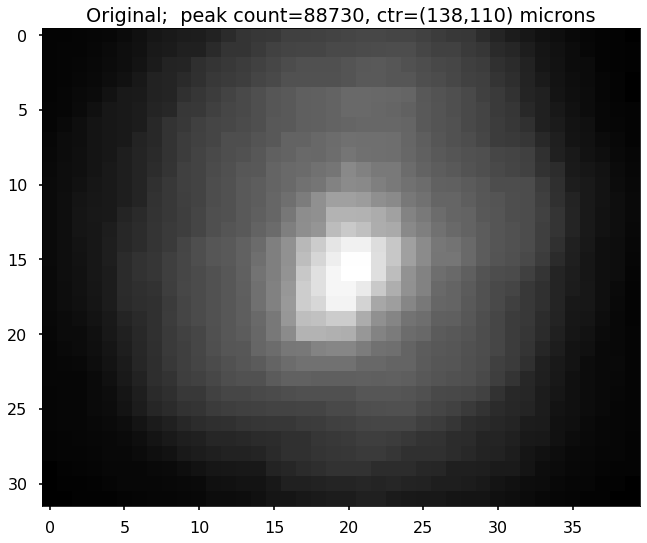

In [8]:
# plot the original image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_orig, cmap='gray', vmin=0., vmax=n0_max)
    ax.set_title('Original;  peak count={0:4.0f}'.format(n0_max)+', ctr=({0:3.0f},'.format(x_center*pixel_size)+'{0:3.0f}) microns'.format(y_center*pixel_size))

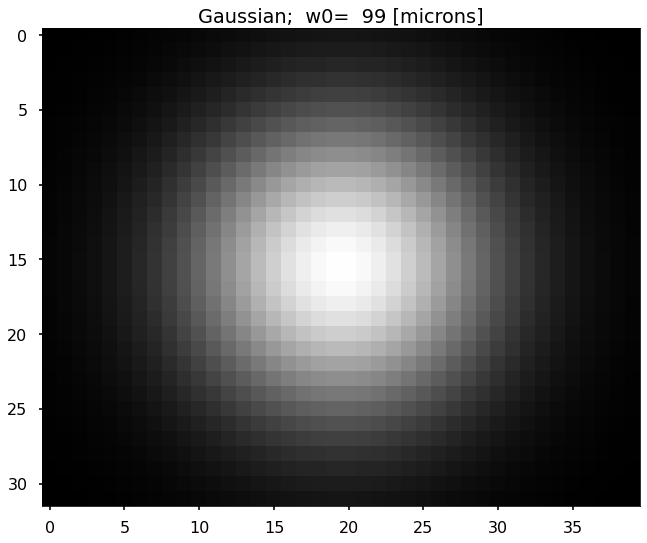

In [9]:
# plot the fitted Gaussian image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_fit, cmap='gray', vmin=0., vmax=n0_max)
    ax.set_title('Gaussian;  w0={0:4.0f} [microns]'.format(w0))

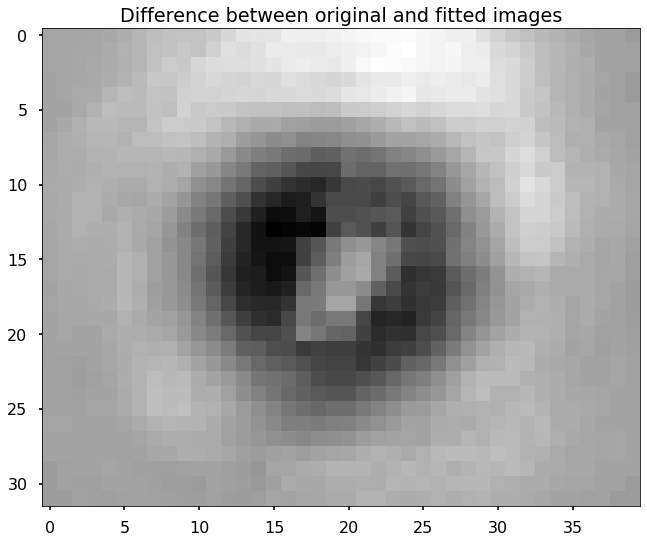

In [10]:
# plot the difference between the original and the Gaussian fit
 
img_diff = img_orig - img_fit
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(img_diff, cmap='gray', vmin=np.min(img_diff), vmax=np.max(img_diff))
    ax.set_title("Difference between original and fitted images")

In [11]:
# how bad are the deviations from original to fitted result (relative to the peak count)?
print(' ')
print('Maximum relative deviation of the Gaussian photon counts, compared to the original --')
print('  above: {0:4.1f} %'.format( 100.*(np.max(img_diff)/n0_max)))
print('  below: {0:4.1f} %'.format(-100.*(np.min(img_diff)/n0_max)))

 
Maximum relative deviation of the Gaussian photon counts, compared to the original --
  above: 21.2 %
  below: 34.1 %


In [12]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('img_orig = ')
# print(img_orig)
min_orig = np.min(img_orig)
max_orig = np.max(img_orig)
print('min original = ', min_orig)
print('max original = ', max_orig)

print(' ')
print('*************************')
# print('img_fit = ')
# print(img_fit)
min_fit = np.min(img_fit)
max_fit = np.max(img_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('img_diff = ')
# print(img_diff)
min_diff = np.min(img_diff)
max_diff = np.max(img_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  0.0
max original =  88730.0
 
*************************
min fitted =  149.7209835550002
max fitted =  88274.02259903317
 
*************************
min diff =  -30218.00757118268
max diff =  18840.351773162223
